# winter 2022 week03

## goals:

reload the data
run util/load_data.py convert_all() function -- which loads everything and converts it to parquet

## todo
- ~add PIPA to list of interesting ones (57 -> 58)~
- final count of reduced fishing
- run the analyze thing over those 7/8
- make those charts of in/out fishing effort of individual ships for those 7/8
- make pictures of before/after fishing effort of individual ships for those 7/8 (could use consistent colors)

THEN:
- make table of (low, low), (low, high), (high, low), (high, high). etc. of the 58
- make table of (?, low), (?, high) of all the other ones

AND THEN:
- compare to the paper about 5 MPAs
- email Dan to show him everything
- title: what can GFW data tell us about the true protection of MPA?
- two effective scenarios: (high, low) and (low, low) ~= (?, low)


## notes:



In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd /Users/brendan/Documents/mpa_project/gfw_research

/Users/brendan/Documents/mpa_project/gfw_research


In [4]:
import numpy as np
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pywdpa
import geopandas
import contextily as ctx
from shapely import geometry
from shapely import ops
import pretty_html_table

import util

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [5]:
DATA_PATH = "/Users/brendan/Documents/mpa_project/gfw_research/data/"
FILENAME = "mpatlas_20201223_clean/mpatlas_20201223_clean.shp"

import util

#mpas = geopandas.read_file(DATA_PATH + FILENAME)
# util.load_mpatlas_mpas()
mpas = geopandas.read_parquet("data/mpas/mpatlas.parquet")

In [6]:
no_take = mpas[(mpas['no_take']=='All') & (mpas['implemente'])]

<AxesSubplot:>

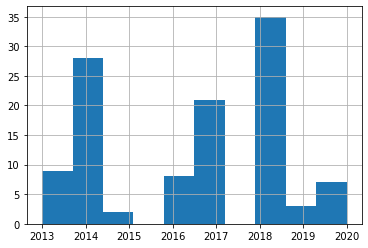

In [8]:
no_take[no_take['status_yea'] > 2012]['status_yea'].hist()


In [10]:
def load_year(year):
    year = str(year)
    print(f'\r reading year {year}', end='')
    return pandas.read_parquet("data/points/" + year + ".parquet")

In [11]:
points_by_year = {
    year : load_year(year)
    for year in range(2012, 2021)
}


 reading year 2020

In [12]:
# sample the points here before converting to geo
# use the sampled points to find the mmsi that are interesting
# only then should we get all of the points of relevent mmsi

SAMPLE_RATIO = 100
points_sampled = []
for year, points in points_by_year.items():
    print(f'\rsampling {str(year)}... ', end='')
    points_sampled.append(points.sample(frac=1/SAMPLE_RATIO))
print('done.')
points_sampled = pandas.concat(points_sampled)
print("converting to geo...  ", end='')
geopoints_sampled = util.convert_to_geo(points_sampled, box=True)
print("done.")


sampling 2020... done.
converting to geo...  done.


In [13]:
of_interest = [
    (555512002, 'Phoenix Island Protected Area', '2015-01-01')
]
for i, row in no_take[no_take['implementa'] > '2012-01-01'].iterrows():
    of_interest.append(
        (row['wdpa_id'], row['name'], row['implementa'])
    )


In [ ]:
tables = pandas.DataFrame()
summed_tables = pandas.DataFrame()
j = 0
for wdpa_id, name, date in of_interest:
    j += 1
    print(f'\r{j}/{len(of_interest)}', end='')
    mpa = mpas[mpas['wdpa_id'] == wdpa_id]
    returned = util.analyze_mpa(geopoints_sampled, points_by_year, mpa, date, plot_pre_post=False)
    if returned:
        table, pre, post, points = returned
        table.insert(0, 'name', name)
        table.insert(1, 'wdpa_id', wdpa_id)
        tables = tables.append(table)
        
        summed = table.groupby('name').aggregate({
            'name': 'first',
            'wdpa_id': 'first',
            'mmsi': 'count',
            'in_pre': 'sum',
            'out_pre': 'sum',
            'in_post': 'sum',
            'out_post': 'sum'})
        summed_tables = summed_tables.append(summed)
    else:
        pass
        # summed_tables = summed_tables.append({'name': mpa.iloc[0]['name']}, ignore_index=True)

4/58

In [ ]:
summed_tables